## Indonesian Fake News Classification

### Dataset
source: https://www.kaggle.com/datasets/vijayandika/hoax-news-indonesia

### Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from wordcloud import WordCloud, STOPWORDS
import re

from nltk.corpus import stopwords
import gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### Dataset

In [21]:
real_news = pd.read_csv("detik.csv")
fake_news = pd.read_csv("turnbackhoax.csv")

In [22]:
real_news['Title']

0           Bekal "Strategic Foresight" untuk Para Capres
1       Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...
2       Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...
3       Relawan Pengusaha Muda Dorong Ekonomi Indonesi...
4       Panda Nababan Sentil Gibran yang Mudah Berkhia...
                              ...                        
2155    Warga Bantargebang Tolak Pembangunan PSEL: Kam...
2156    Polda Metro Dalami Foto Pertemuan SYL dan Firl...
2157    Gelar World Walking Day, Walkot Tangerang: Mud...
2158    Punya Gen Pemicu Alzheimer, Chris Hemsworth Ma...
2159    Gebyar Hari Jantung Sedunia, Bupati Mojokerto ...
Name: Title, Length: 2160, dtype: object

In [23]:
real_news

,Title,Text,Date,Link,Category
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,"detikNewsKamis, 02 Nov 2023 11:15 WIB",https://news.detik.com/kolom/d-7013788/bekal-s...,Politik
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,"detikFinanceKamis, 02 Nov 2023 11:15 WIB",https://finance.detik.com/berita-ekonomi-bisni...,Politik
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,"detikNewsKamis, 02 Nov 2023 11:11 WIB",https://news.detik.com/berita/d-7015092/kapan-...,Politik
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,"detikNewsKamis, 02 Nov 2023 11:04 WIB",https://news.detik.com/berita/d-7015074/relawa...,Politik
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,"detikSumbagselKamis, 02 Nov 2023 10:25 WIB",https://www.detik.com/sumbagsel/berita/d-70149...,Politik
...,...,...,...,...,...
2155,Warga Bantargebang Tolak Pembangunan PSEL: Kam...,"Warga Bantargebang, Kota Bekasi, menolak renca...","detikNewsSabtu, 07 Okt 2023 17:07 WIB",https://news.detik.com/berita/d-6970285/warga-...,Olahraga
2156,Polda Metro Dalami Foto Pertemuan SYL dan Firl...,Polda Metro Jaya dalami foto pertemuan Ketua K...,"detikSumbagselSabtu, 07 Okt 2023 16:49 WIB",https://www.detik.com/sumbagsel/hukum-dan-krim...,Olahraga
2157,"Gelar World Walking Day, Walkot Tangerang: Mud...",Pemerintah Kota (Pemkot) Tangerang sukses meng...,"detikNewsSabtu, 07 Okt 2023 16:06 WIB",https://news.detik.com/berita/d-6970204/gelar-...,Olahraga
2158,"Punya Gen Pemicu Alzheimer, Chris Hemsworth Ma...",Hemsworth disebut memiliki risiko tinggi mengi...,"detikHealthSabtu, 07 Okt 2023 16:00 WIB",https://health.detik.com/berita-detikhealth/d-...,Olahraga


In [24]:
fake_news

,Title,Text,Date,Link,Category
0,[SALAH] Perhelatan Puncak Balapan Formula E Se...,Hasil Periksa Fakta Novita Kusuma Wardhani. In...,"Juni 17, 2022",https://turnbackhoax.id/2022/06/17/salah-perhe...,Olahraga
1,[SALAH] “HRS dilaporkan tewas tertabrak Unta p...,Informasi palsu. Berdasar pada penggunaan kata...,"September 22, 2020",https://turnbackhoax.id/2020/09/22/salah-hrs-d...,Olahraga
2,[SALAH] Formula E Tidak Disiarkan oleh TV Nasi...,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,"Juni 13, 2022",https://turnbackhoax.id/2022/06/13/salah-formu...,Olahraga
3,[SALAH]: Formula E Jakarta Masuk Rekor Dunia S...,Informasi menyesatkan. Berdasarkan dari pember...,"Juni 6, 2022",https://turnbackhoax.id/2022/06/06/salah-formu...,Olahraga
4,[SALAH]: Barang-barang Pemberian Pembalap Moto...,Bukan barang-barang yang diberikan kepada peno...,"April 1, 2022",https://turnbackhoax.id/2022/04/01/salah-baran...,Olahraga
...,...,...,...,...,...
2147,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,"Juli 2, 2018",https://turnbackhoax.id/2018/07/02/salah-seora...,Olahraga
2148,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-marad...,Olahraga
2149,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-wakap...,Olahraga
2150,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,"Juni 25, 2018",https://turnbackhoax.id/2018/06/25/benar-foto-...,Olahraga


In [25]:
print("Banyak data berita benar: ", real_news.shape[0])
print("Banyak data berita palsu: ", fake_news.shape[0])

Banyak data berita benar:  2160
Banyak data berita palsu:  2152


#### Histogram

Politik      720
Teknologi    720
Olahraga     720
Name: Category, dtype: int64

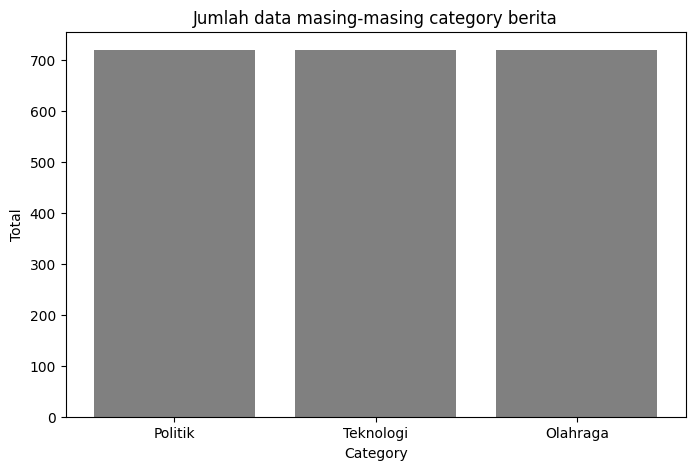

In [26]:
### Tabel Frekuensi
category_series = real_news["Category"]

# Convert to freq table
freq_table = category_series.value_counts()
display(freq_table)

### Bar Chart
# Membangun list nilai x dan y untuk digambar di bar chart
x = freq_table.index.to_list()
y = freq_table.to_list()

# mendefinisikan kanvas untuk menggambar diagram
fig = plt.figure(figsize =(8, 5)) 

# perintah untuk menggambar diagram di kanvas
plt.bar(x, y, color='grey')

# perintah untuk memberi label sumbu x dan y
plt.xlabel("Category")
plt.ylabel("Total")

# perintah untuk memberi judul diagram
plt.title("Jumlah data masing-masing category berita")

# perintah untuk menampilkan gambar di kanvas
plt.show()

### Data Preprocessing

#### Penggabungan tabel

In [27]:
real_news['Is_Fake'] = 0
fake_news['Is_Fake'] = 1
df_concatenated = pd.concat([real_news, fake_news]).reset_index(drop=True)
df_concatenated

,Title,Text,Date,Link,Category,Is_Fake
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,"detikNewsKamis, 02 Nov 2023 11:15 WIB",https://news.detik.com/kolom/d-7013788/bekal-s...,Politik,0
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,"detikFinanceKamis, 02 Nov 2023 11:15 WIB",https://finance.detik.com/berita-ekonomi-bisni...,Politik,0
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,"detikNewsKamis, 02 Nov 2023 11:11 WIB",https://news.detik.com/berita/d-7015092/kapan-...,Politik,0
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,"detikNewsKamis, 02 Nov 2023 11:04 WIB",https://news.detik.com/berita/d-7015074/relawa...,Politik,0
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,"detikSumbagselKamis, 02 Nov 2023 10:25 WIB",https://www.detik.com/sumbagsel/berita/d-70149...,Politik,0
...,...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,"Juli 2, 2018",https://turnbackhoax.id/2018/07/02/salah-seora...,Olahraga,1
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-marad...,Olahraga,1
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-wakap...,Olahraga,1
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,"Juni 25, 2018",https://turnbackhoax.id/2018/06/25/benar-foto-...,Olahraga,1


#### Mengubah Nilai Is_Fake pada Setiap Baris yang memiliki "[BENAR]" atau "(BENAR)" pada judul

In [28]:
df_concatenated.loc[df_concatenated['Title'].str.contains("BENAR"), "Is_Fake"] = 0

#### Menghapus kolom yang tidak berguna
Kolom date dan link tidak akan kami pakai karena tidak memberikan pengaruh terhadap pemodelan NLP. Waktu kapan berita diunggah tidak menentukan bahwa berita tersebut hoax atau tidak.

In [29]:
df_concatenated.drop(columns=['Date', 'Link'], inplace=True)

#### Membuat kolom tambahan untuk menggabung judul dan isi berita

In [30]:
df_concatenated['Content'] = df_concatenated['Title'] + " " + df_concatenated['Text']
df_concatenated.head()

,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,"Bekal ""Strategic Foresight"" untuk Para Capres ..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,Panda Nababan Sentil Gibran yang Mudah Berkhia...


#### Case Folding
Mengubah teks menjadi huruf kecil (*lowercase*) adalah langkah penting dalam melatih model klasifikasi NLP (Natural Language Processing). Hal ini dilakukan untuk menjaga konsistensi dalam pemrosesan teks, mencegah duplikasi kata karena perbedaan penulisan huruf besar dan kecil, normalisasi data teks, mengurangi dimensi kata, mengurangi risiko overfitting, dan meningkatkan efisiensi pemrosesan secara keseluruhan. 

In [31]:
df_concatenated['Content'] =  df_concatenated['Content'].apply(lambda x: x.lower())
df_concatenated

,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,"bekal ""strategic foresight"" untuk para capres ..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo-gibran? ini jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...
...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,[salah]: seorang ibu-ibu meninggal akibat terp...
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,0,[benar]: maradona bantah kabar dirinya meningg...
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,0,[benar] wakapolri tidak pernah beri pernyataan...
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,0,[benar] “foto wanita iran yang menonton piala ...


#### Erasing Punctuation
Pada bagian ini kita mengambil data title dan juga menghapus setiap karakter "punctuation" dan juga "bracket". Setelah kita sudah memfilter setiap karakter selain alphabet, kita akan memasukannya kedalam satu kolom yang bernama 'Content' supaya data tersebut bisa lebih mudah kita proses.

In [32]:
### Erasing Punctuation
df_concatenated['Content'] = df_concatenated['Content'].str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
df_concatenated


,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,bekal strategic foresight untuk para capres ...
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo gibran ini jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...
...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,salah seorang ibu ibu meninggal akibat terp...
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,0,benar maradona bantah kabar dirinya meningg...
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,0,benar wakapolri tidak pernah beri pernyataan...
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,0,benar foto wanita iran yang menonton piala ...


#### Menghilangkan Stop Words bahasa Indonesia

In [33]:
stop_words = stopwords.words('indonesian')
stop_words.extend(['dari', 'subjek', 're', 'edu', 'penggunaan', 'salah', 'benar'])


def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)
  return result


df_concatenated['Stopword_Filtered'] = df_concatenated['Content'].apply(preprocess)

print("Stopword_Filtered Version:", '\n', df_concatenated['Stopword_Filtered'][0])



Stopword_Filtered Version: 
 ['bekal', 'strategic', 'foresight', 'capres', 'pandangan', 'foresight', 'dimiliki', 'capres', 'cawapres', 'bangsa', 'situasi', 'dunia', 'rentan', 'kompleks']


#### Stemming (Penyederhanaan Kata)
Teknik *stemming* atau penyederhanaan kata adalah proses untuk menghapus imbuhan kata agar hanya menyisakan akar kata atau kata dasarnya. Ini dilakukan dengan menghapus imbuhan seperti akhiran -ing, -es, -ed, dan lainnya sehingga kata yang memiliki makna serupa tetapi ditulis secara berbeda dapat dianggap sama. Dalam konteks klasifikasi masalah NLP (Natural Language Processing), teknik stemming penting karena membantu mengurangi kompleksitas data teks. Dengan mengonversi kata-kata ke bentuk dasarnya, seperti mengubah "berlari" menjadi "lari" atau "makanan" menjadi "makan", kita dapat meningkatkan konsistensi dan kesamaan antara kata-kata yang sebenarnya memiliki makna yang sama. Hal ini membantu meningkatkan akurasi model klasifikasi karena model dapat fokus pada makna inti dari kata-kata tanpa terganggu oleh variasi penulisan yang berbeda. Stemming juga membantu mengurangi dimensi fitur dalam data teks, sehingga meningkatkan efisiensi komputasi dan memungkinkan model bekerja lebih baik terutama pada data dengan kosakata yang luas.

In [34]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(token_list):
    return [stemmer.stem(token) for token in token_list]


df_concatenated['Stemmed'] = df_concatenated['Stopword_Filtered'].apply(stemming)

KeyboardInterrupt: 

### Save tabel

In [ ]:
df_concatenated.to_csv("./cleaned.csv", index=False)

### EDA

In [35]:
cleaned_df = pd.read_csv("cleaned.csv", converters={'Stemmed': pd.eval})
cleaned_df

,Title,Text,Category,Is_Fake,Content,Stopword_Filtered,Stemmed
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,bekal strategic foresight untuk para capres ...,"['bekal', 'strategic', 'foresight', 'capres', ...","[bekal, strategic, foresight, capres, pandang,..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...,"['mendag', 'zulhas', 'pengaruh', 'geopolitik',...","[mendag, zulhas, pengaruh, geopolitik, dagang,..."
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo gibran ini jawab...,"['pengumuman', 'prabowo', 'gibran', 'gerindra'...","[umum, prabowo, gibran, gerindra, ketua, hari,..."
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...,"['relawan', 'pengusaha', 'muda', 'dorong', 'ek...","[rawan, usaha, muda, dorong, ekonomi, indonesi..."
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...,"['panda', 'nababan', 'sentil', 'gibran', 'muda...","[panda, nababan, sentil, gibran, mudah, khiana..."
...,...,...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,salah seorang ibu ibu meninggal akibat terp...,"['meninggal', 'akibat', 'terperosok', 'setu', ...","[tinggal, akibat, perosok, setu, babakan, jaga..."
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,0,benar maradona bantah kabar dirinya meningg...,"['maradona', 'bantah', 'kabar', 'meninggal', '...","[maradona, bantah, kabar, tinggal, laga, argen..."
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,0,benar wakapolri tidak pernah beri pernyataan...,"['wakapolri', 'pernyataan', 'terkait', 'pilkad...","[wakapolri, nyata, kait, pilkada, kota, makass..."
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,0,benar foto wanita iran yang menonton piala ...,"['foto', 'wanita', 'iran', 'menonton', 'piala'...","[foto, wanita, iran, tonton, piala, dunia, hij..."


#### Wordcloud

##### Berita Benar

In [36]:
real_text = ""
for _, row in cleaned_df[cleaned_df['Is_Fake'] == 0].iterrows():
    real_text += " ".join(row['Stemmed'])

(-0.5, 1599.5, 799.5, -0.5)

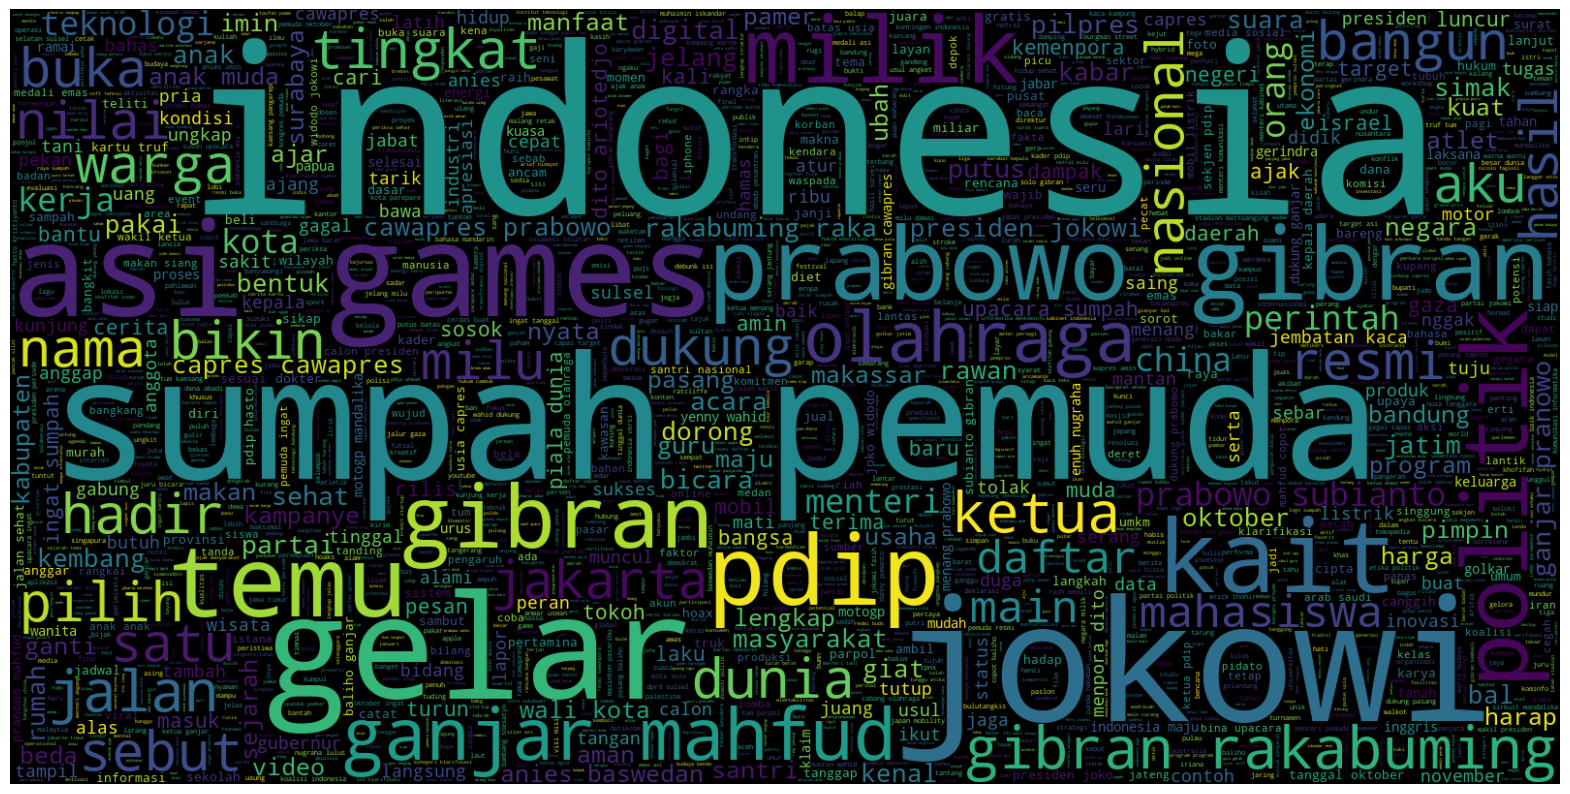

In [37]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(real_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [38]:
fake_text = ""
for _, row in cleaned_df[cleaned_df['Is_Fake'] == 1].iterrows():
    fake_text += " ".join(row['Stemmed'])

(-0.5, 1599.5, 799.5, -0.5)

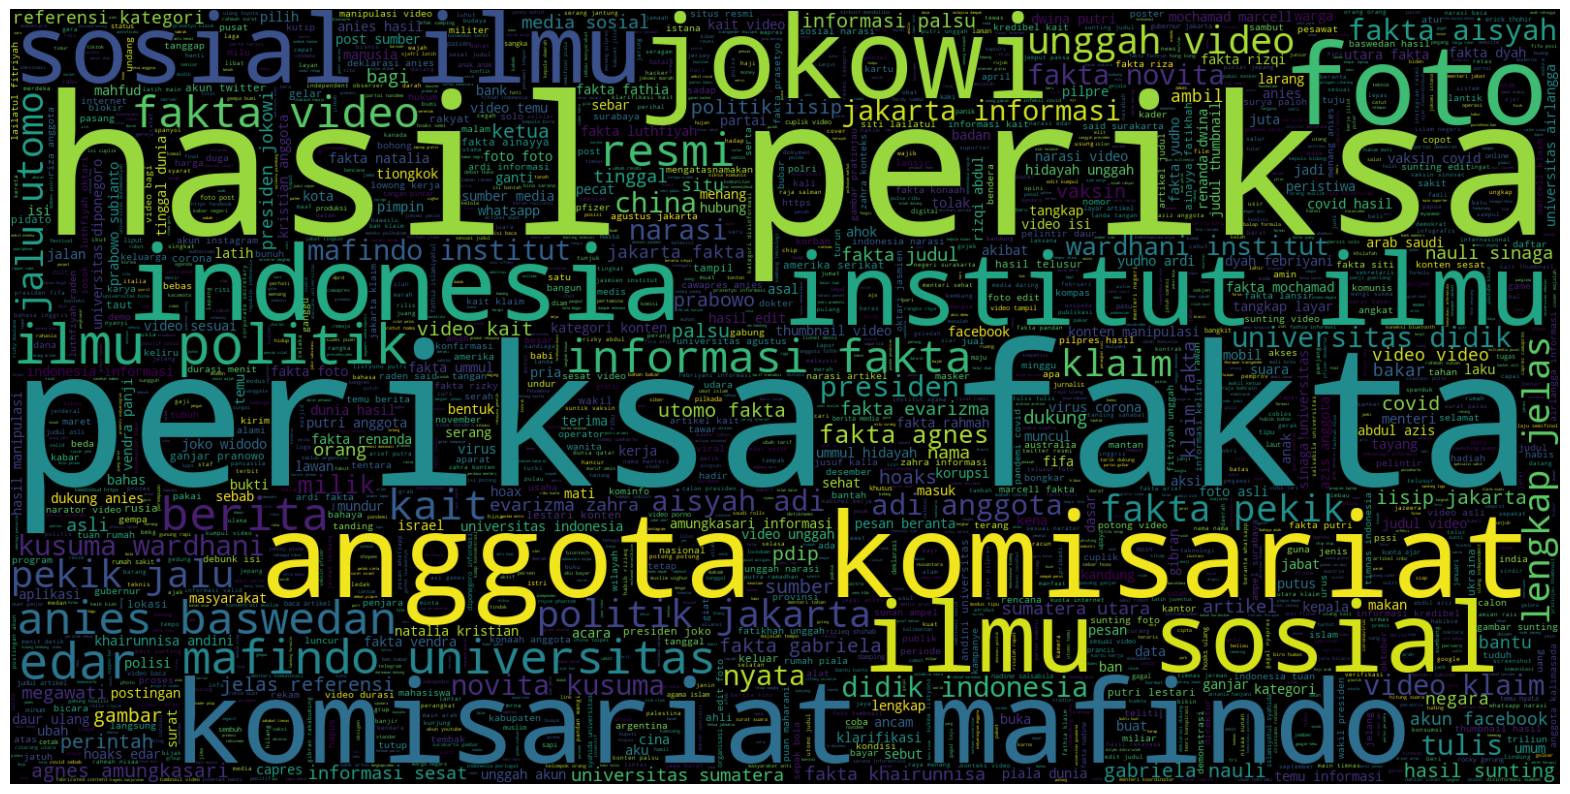

In [39]:
plt.figure(figsize=(20,20))
wordcloud2 = WordCloud(max_words=2000, width=1600, height=800).generate(fake_text)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

### Modelling

In [40]:
X = cleaned_df['Stemmed'].apply(lambda x: " ".join(x))
y = cleaned_df['Is_Fake']

#### Train-test split

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### Gradient Boosting

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Defining Pipeline
pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('clf', GradientBoostingClassifier()) 
])

# Defining param_grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],     # Uni-gram and bi-gram
    'clf__learning_rate': [0.1, 0.01, 0.001],   # Learning rate 
    'clf__n_estimators': [100, 500, 1000],      # Number of trees 
    'clf__max_depth': [3, 5, 7]                 # Maximum depth of trees 
}

# Defining stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline_gb, param_grid, cv=stratified_kfold, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Using best parameter to make new pipeline
best_params = grid_search.best_params_
best_pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=best_params['tfidf__ngram_range'])),
    ('clf', GradientBoostingClassifier(
        learning_rate=best_params['clf__learning_rate'],
        n_estimators=best_params['clf__n_estimators'],
        max_depth=best_params['clf__max_depth']
    ))
])


KeyboardInterrupt: 

In [ ]:
best_pipeline_gb.fit(X_train, y_train)
y_pred_gb = best_pipeline_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb))

#### Naive Bayes Classifier

##### Mengapa Multinomial Naive Bayes?

Multinomial Naive Bayes sering dipilih untuk klasifikasi berita palsu karena cocok untuk data teks, mampu menangani multi-kategori, dan relatif mudah diimplementasikan. Model ini mengatasi representasi vektor frekuensi kata-kata dalam teks, dapat membedakan antara berita palsu dan bukan berita palsu, serta memberikan hasil yang baik dalam praktiknya. Meskipun asumsi independensi yang sangat bersyarat, model ini sering memberikan hasil yang memuaskan dan mudah diinterpretasikan, menjadikannya pilihan yang populer untuk tugas klasifikasi teks seperti ini. Namun, pemilihan model harus selalu disesuaikan dengan karakteristik data dan tujuan analisis yang spesifik.

##### Apa itu Hyperparameter Alpha pada Multinomial Naive Bayes
Dalam konteks Multinomial Naive Bayes, hyperparameter alpha mengacu pada parameter smoothing yang digunakan untuk menangani kasus di mana probabilitas suatu fitur (kata-kata dalam teks) muncul dalam kelas tertentu adalah nol (probabilitas nol).

Penggunaan alpha dalam model Multinomial NB membantu mengatasi masalah probabilitas nol yang dapat muncul saat menghitung probabilitas posterior untuk kelas tertentu jika terdapat fitur (kata) yang tidak muncul dalam kelas tersebut pada data pelatihan. Alpha merupakan nilai tambahan yang ditambahkan pada semua frekuensi fitur dalam setiap kelas, sehingga tidak ada probabilitas nol yang muncul.

Dengan menentukan nilai alpha yang sesuai, kita dapat mengontrol seberapa kuat dampak smoothing yang diberikan pada model. Nilai alpha yang lebih besar memberikan smoothing yang lebih kuat, sementara nilai alpha yang lebih kecil memberikan smoothing yang lebih lemah. Pemilihan nilai alpha yang optimal dapat membantu meningkatkan kinerja model Multinomial NB terutama saat menghadapi data dengan fitur jarang atau kasus di mana terdapat probabilitas nol yang signifikan.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define the pipeline
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF vectorization
    ('clf', MultinomialNB()),  # Naive Bayes classifier
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Uni-gram and bi-gram
    'clf__alpha': [0.1, 1.0, 10.0],  # Smoothing parameter for Naive Bayes
}

# Define the stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_nb, param_grid, cv=stratified_kfold, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best parameters to create a new pipeline
best_params = grid_search.best_params_
best_pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=best_params['tfidf__ngram_range'])),
    ('clf', MultinomialNB(alpha=best_params['clf__alpha']))
])

# Fit the new pipeline to the data

Best parameters: {'clf__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Best score: 0.9461891951584904


In [44]:
best_pipeline_nb.fit(X_train, y_train)
y_pred_nb = best_pipeline_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       564
           1       0.94      0.97      0.95       514

    accuracy                           0.95      1078
   macro avg       0.95      0.95      0.95      1078
weighted avg       0.95      0.95      0.95      1078



#### Passive Aggressive

#### Mengapa Passive Aggresive?

Penggunaan classifier pasif agresif memiliki beberapa keuntungan yang signifikan. Pertama, mereka terkenal karena kemampuan pembelajaran cepatnya, sering kali konvergen dengan cepat, sehingga cocok untuk situasi di mana sumber daya komputasi atau waktu terbatas. Kedua, efisiensi memori mereka yang tinggi membuatnya cocok untuk penanganan kumpulan data besar atau lingkungan memori yang terbatas karena hanya perlu menyimpan sejumlah kecil informasi tentang data yang dilihat. Ketiga, ketangguhan terhadap noise dan outlier dalam data membuatnya menjadi pilihan yang tangguh, berkat mekanisme pembaruan yang disesuaikan dengan kesalahan yang diamati, memungkinkan adaptasi tanpa overfitting. Terakhir, kemampuan adaptasi mereka yang luas membuat mereka dapat diterapkan pada berbagai tugas klasifikasi, dari klasifikasi teks hingga klasifikasi gambar, sehingga cocok untuk berbagai domain dan aplikasi.

#### Apa itu Hyperparameter c pada Passive Aggresive?

Nilai `C` mempengaruhi sejumlah hal. Pertama, sebagai kekuatan regularisasi, `C` mempengaruhi seberapa kuat model menyesuaikan dengan data pelatihan, dengan nilai yang lebih tinggi menghasilkan penyesuaian yang lebih ketat dan kemungkinan overfitting, sementara nilai yang lebih rendah cenderung menghasilkan penyesuaian yang lebih longgar dan mungkin menghindari overfitting. Selain itu, `C` juga mempengaruhi lebar margin, di mana nilai yang lebih tinggi menghasilkan margin yang lebih kecil dan sensitivitas yang lebih tinggi terhadap titik data individual, sedangkan nilai yang lebih rendah menghasilkan margin yang lebih besar dan toleransi yang lebih tinggi terhadap kesalahan.

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF vectorization
    ('clf', PassiveAggressiveClassifier()),  # Passive Aggressive classifier
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Uni-gram and bi-gram
    'clf__C': [0.1, 1.0, 10.0],  # Regularization parameter for Passive Aggressive Classifier
}

# Define the stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best parameters to create a new pipeline
best_params = grid_search.best_params_
best_pipeline_pac = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=best_params['tfidf__ngram_range'])),
    ('clf', PassiveAggressiveClassifier(C=best_params['clf__C']))
])


Best parameters: {'clf__C': 0.1, 'tfidf__ngram_range': (1, 2)}
Best score: 0.9532624226845666


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', PassiveAggressiveClassifier(C=0.1))])

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
best_pipeline_pac.fit(X_train, y_train)
y_pred = best_pipeline_pac.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       564
           1       0.95      0.96      0.95       514

    accuracy                           0.96      1078
   macro avg       0.96      0.96      0.96      1078
weighted avg       0.96      0.96      0.96      1078

